# Traveling Salesman Problem - Genetic Algorithms

This notebook contains a pretty straightforward approach to solve the TSP, using a genetic algorithm.

### Some Julia Models

In [1]:
using DelimitedFiles

using Plots
using GraphRecipes

using Random.Random
using StatsBase
using Distributions
using LinearAlgebra

### Data Description
Our data contains distances between 15 different cities. This can be represented in the form of a **symmetric adjacency matrix** as the data forms a fully connected graph.

In [2]:
ζ = Symmetric(readdlm("cities.txt", Int64))

15×15 Symmetric{Int64,Array{Int64,2}}:
  0  29  82  46  68  52  72  42  51  55  29  74  23  72  46
 29   0  55  46  42  43  43  23  23  31  41  51  11  52  21
 82  55   0  68  46  55  23  43  41  29  79  21  64  31  51
 46  46  68   0  82  15  72  31  62  42  21  51  51  43  64
 68  42  46  82   0  74  23  52  21  46  82  58  46  65  23
 52  43  55  15  74   0  61  23  55  31  33  37  51  29  59
 72  43  23  72  23  61   0  42  23  31  77  37  51  46  33
 42  23  43  31  52  23  42   0  33  15  37  33  33  31  37
 51  23  41  62  21  55  23  33   0  29  62  46  29  51  11
 55  31  29  42  46  31  31  15  29   0  51  21  41  23  37
 29  41  79  21  82  33  77  37  62  51   0  65  42  59  61
 74  51  21  51  58  37  37  33  46  21  65   0  61  11  55
 23  11  64  51  46  51  51  33  29  41  42  61   0  62  23
 72  52  31  43  65  29  46  31  51  23  59  11  62   0  59
 46  21  51  64  23  59  33  37  11  37  61  55  23  59   0

Below is a visualization of our data in three dimensional space, `z-offset` being random, for purely aesthetic reasons.

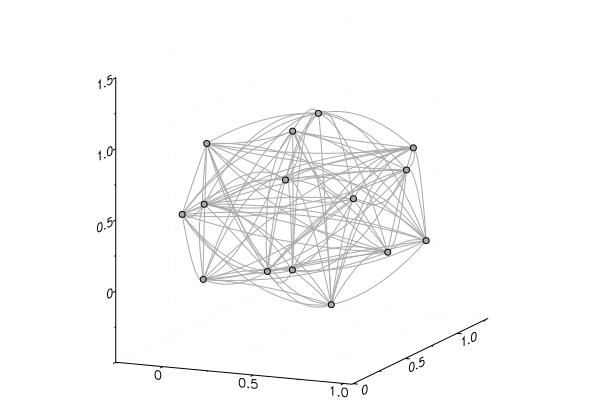

In [3]:
graphplot(ζ, markersize=3, markercolor=:darkgrey, dim=3, linecolor=:darkgrey)

### Encoding strategy: Permutation Encoding
We extend the shuffle function to strings so that it may be able to create its random permutations.

In [4]:
Random.shuffle(s::String) = isascii(s) ? s[randperm(end)] : join(shuffle!(collect(s)))
example = "abcdef"
shuffle(example)

"ecabdf"

## Describing the genetic algorithm
### 1. Fitness function
A fitness function is described here so that we may be able to assign a *score* to each permutation, this score in turn gives us the degree to which the specific individual is likely to be selected in the next generation.

$\boxed{\Phi(p) = \frac{1}{\sum\limits_{i=1}^{k-1}\text{dist(i, i+1)}}}$ <br>

Where k is the number of cities or **genes.** 

In [5]:
function Φ(
        p::String # An individual of the population.
    )::Float64
    
    ϕ = 0
    
    for i=1:length(p) - 1
        ϕ += ζ[Int(p[i]) - 64, Int(p[i + 1]) - 64]
    end
    
    return 1 / ϕ
end

Φ (generic function with 1 method)

### 2. Selection Operator
For our selection operator, we have considered the **roulette-wheel algorithm.** Where likeliness of selection depends on the fitness of the individuals.

In [6]:
function ∇(
        P::Array{String,1},  # The population of all samples.
        ω::Array{Float64,1}, # Weight vector governing probability of selection.
        μ::Int64             # Number of samples.
    )::Array{String,1}

    # Will contain selected samples.
    β = String[]
    
    for i=1:μ
        
        # Cumulative sum and index counter.
        Σ = 0 
        i = 0

        # A random selection from a normal distribution.
        ϕ = rand(Uniform(0, 1))

        while Σ <= ϕ
            i = i % μ + 1
            Σ += ω[i]
        end

        push!(β, P[i])
    end
    
    # Only return unique samples, no repeats.
    return unique!(β)
end

∇ (generic function with 1 method)

### 3. Cross-over Operator
Here, we use **percedance perserving** cross over technique to generate the new generation, where based on a certain mask,  distinct genes are selected from each parent, producing two offsprings.

In [7]:
function ⊗(
        β::Array{String,1}, # Selected samples.
        η::Int64,           # Number of genes.
        δ::String           # Masking string.
    )::Array{String, 1} 
    
    βn = length(β)
    
    # Will hold all new offsprings
    α = String[]
    
    # Creating all possible pairs of selected samples and crossing them over.
    for i=1:βn-1
        for j=i+1:βn
            c1 = Δ(β[i], β[j], δ, η)
            c2 = Δ(β[j], β[i], δ, η)
            append!(α, [c1, c2])
        end
    end
    
    return unique!(α)
end

⊗ (generic function with 1 method)

In [8]:
function Δ(
        ρ1::String, # parent 1.
        ρ2::String, # parent 2.
        δ::String,  # masking string.
        η::Int64    # number of genes.
    )::String
    
    # Offspring
    θ = Char[]
    
    i = j = k = 1 

    # PPCrossover operation
    while i <= η
    
        if δ[i] == '0'
            if ρ1[j] in θ
                j += 1
            else
                push!(θ, ρ1[j])
                i += 1
            end
                
        else
            if ρ2[k] in θ
                k += 1
            else
                push!(θ, ρ2[k])
                i += 1
            end
        end
    end
    
    # Returned as a string.
    return join(θ)
end

Δ (generic function with 1 method)

### 4. Mutation
To increase the stochastic nature of the algorithm, in each generation, we can select an indiviudal and randomly alter one of it's genes. This helps us have a diverse sample.

In [9]:
function γ(
        α::Array{String,1},
        η::Int64
    )
    
    # Select two random genes to be swapped.
    γ1, γ2 = Random.rand(1:η, 2)
    
    l = length(α)
    
    if l >= 1
        
        # Select a random individual.
        λ = Random.rand(1:l)
    
    
        s = collect(α[λ])
    
        # Swap the two genes.
        τ = s[γ1]
        s[γ1] = s[γ2]
        s[γ2] = τ
        
        α[λ] = join(s) 
    end
end

γ (generic function with 1 method)

### 5. New population
$\Gamma$ decides which individuals will be considered in the next population. Here we are selecting the fittest individuals among both parents and offsprings. This corresponds to what is known as a **very high selection pressure.** This technique leads to **faster convergence** to the soultion but is not optimal incase there are many soultions since the solution is very likley to be a **local minima or maxima**. To avoid this other techniques such as **stratified sampling** can be done.

In [10]:
function ∏(
        P::Array{String,1}, # Parents.
        α::Array{String,1}, # Offspings.
        μ::Int64            # Number of samples in a population.
    )
    
    α = append!(P, α)
    
    Φv = [Φ(ι) for ι in α]
    k = sortperm(Φv, rev=true)

    # Sort as per fitness, high to low.
    α = α[k]
  
    # Select fittest of all.
    return α[1 : min(μ, length(α))]
end

∏ (generic function with 1 method)

### 6. Final Algorithm
We repeat the above steps, breeding one generation after another. Our population favours high fitness, making our function converge to a solution. The parameter being used to evalute the algorithm is average fitness of the successive generations.

In [11]:
function Γ(
        η::Int64, # Number of genes.
        μ::Int64, # Number of samples.
        τ::Int64, # Number of generations.
        δ::String # Masking String.
    )::Float64
    
    # Encoding Strategy
    ψ = join([Char(64 + i) for i=1:η])
    
    # Sample Generation (Permutation Encoding)
    P = [shuffle(ψ) for i=1:μ]
    
    # For each generation
    for i=1:τ
        
        # Calculate a fitness vector of all samples.
        Φv = Float64[]
        for p in P
            push!(Φv, Φ(p))
        end
        
        # Calculate a weight vector coressponding to individual fintness values.
        ΦT = sum(Φv) 
        ω  = [ϕ / ΦT for ϕ in Φv]
         
        # Selection Operation
        β = ∇(P, ω, μ)
        
        # Cross-over Operation
        α = ⊗(β, η, δ)
        
        # Mutation Opration
        γ(α, η)
        
        # New Population Selection
        P = ∏(P, α, μ)
    end
    
    # Average fitness of each generation
    Φavg = sum([Φ(ι) for ι in P]) / μ
    
    return Φavg 
end

Γ (generic function with 1 method)

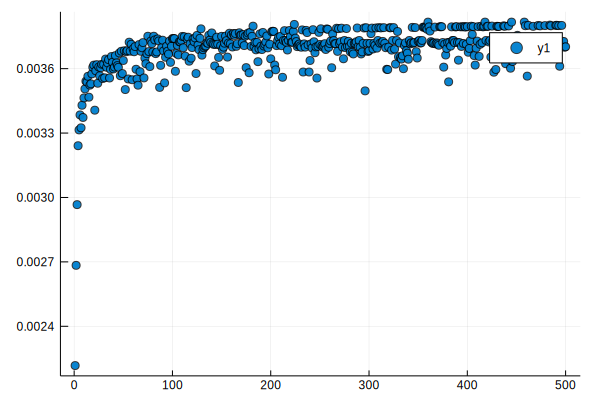

In [12]:
x = collect(1:1:500)
y = Float64[]

for i in x
    push!(y, Γ(15, 500, i, "001100110011001"))
end

scatter(x, y, alpha=0.8)

## Conclusion
From the above scatter plot we can infer  that our algorithm makes our objective function converge to a solution.